<a href="https://colab.research.google.com/github/AAndreevich/master/blob/master/HW4_Regression_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####     1 В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

####    2 Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.



In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import model_selection

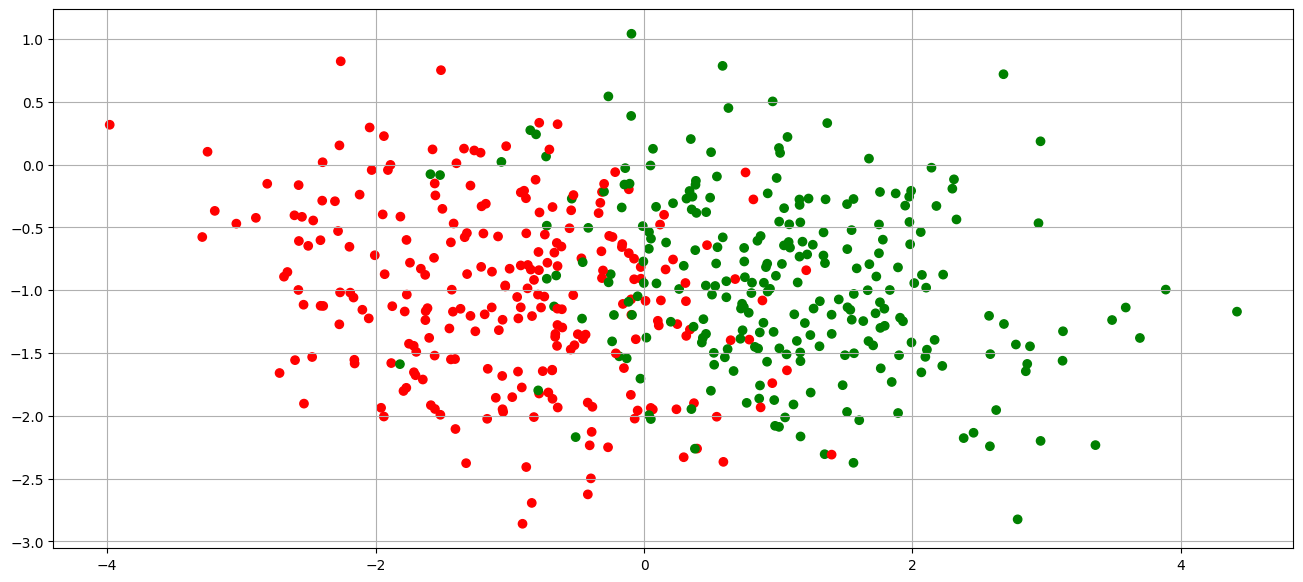

In [2]:
# Генерация массива даных
classification_data, classification_labels = datasets.make_classification(n_samples=500, n_features=2, n_informative=2,
                                                                         n_classes=2, n_redundant=0,
                                                                         n_clusters_per_class=1, random_state=47)

# Визуализация сгенерированного массива
colors = ListedColormap(['red', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightgreen'])

plt.figure(figsize=(16,7))
plt.scatter(classification_data.T[0], classification_data.T[1], c=classification_labels, cmap=colors)
plt.grid()
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 47)

In [5]:
# Реализация класса узла
class Node:

    def __init__(self, index, treshold, true_branch, false_branch):
        """index - Значение для сравнения с порогом
            treshold -  порог
            true_branch - поддерево удовлетворяющее условию в узле
            false_branch - поддерево НЕ удовлетворяющее условию в узле"""
        self.index = index
        self.treshold = treshold
        self.true_branch = true_branch
        self.false_branch = false_branch



# Реализация класса листа (терминальный узел)
class Leaf:

    def __init__(self, data, labels, condition=1):
        """data - features
            labels - target y_true
            condition - Условие для выбора расчета предсказания 1 - это среднее по выборке,
            0 - это поиск максимального количества объектов в листе
            по умолчанию condition=1"""
        self.data = data
        self.labels = labels
        self.condition = condition
        self.prediction = self.predict() # y_pred

    def predict(self):
        if self.condition == 0:
            # Подсчет количества объектов разных классов
            classes = {}
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1
            # Записываем в prediction класс с максимальным количеством объектов в листе
            prediction = max(classes, key=classes.get)
            return prediction
        else:
            # Среднее по выборке
            return np.mean(self.labels)

        
# Общий класс для обработки ипостроения дерева решений
class SolveBuildTree:
    
    def __init_(self):
        self.Node = Node()
        self.Leaf = Leaf()
        
    @classmethod
    def dispertion(cls, labels):
        """Расчет дисперсии вокруг среднего"""
        mean_lebels = np.mean(labels)
        Dis_list = [(label - mean_lebels)**2 for label in labels]    
        return np.mean(Dis_list)

    @classmethod
    def quality(cls, left_labels, right_labels, current_dispertion):
        """Расчет качества"""
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_dispertion - p * SolveBuildTree.dispertion(left_labels) - (1 - p) * SolveBuildTree.dispertion(right_labels)

    @classmethod
    def split(cls, data, labels, index, treshold):
        """Разбиение датасета в узле"""

        left = np.where(data[:, index] <= treshold)
        right = np.where(data[:, index] > treshold)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    @classmethod
    def find_best_split(cls, data, labels, min_leaf, qual):
        """Нахождение наилучшего разбиение"""
        
        """min_leaf - минимальное количество объектов в узле"""

        """Поиск дисперсии среднего по выборке"""
        current_dispersion = SolveBuildTree.dispertion(labels)

        best_quality = qual
        best_treshold = None
        best_index = None

        """Устанавливаем количество признаков"""
        n_features = data.shape[1]

        for index in range(n_features):
            treshold_value = [row[index] for row in data]
            for treshold in treshold_value:
                true_data, false_data, true_labels, false_labels = SolveBuildTree.split(data, labels, index, treshold)
                """Пропуск разбиений, если в узле менее min_leaf объектов"""
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                current_quality = SolveBuildTree.quality(true_labels, false_labels, current_dispersion)

                """Выбор порога с максимальным приростом качества"""
                if current_quality > best_quality:
                    best_quality, best_treshold, best_index = current_quality, treshold, index

        return best_quality, best_treshold, best_index

    @classmethod
    def build_tree(cls, data, labels, min_leaf=2, qual=0, count=0, max_depth=np.inf):
        """Построение дерева посредством рекурсивной функции"""
        """min_leaf - минимальное количество объектов в узле"""
        cls.max_depth = max_depth
        
        quality, treshold, index = SolveBuildTree.find_best_split(data, labels, min_leaf, qual)

        """Перкращение рекурсии в зависимости от качества"""
        if quality == qual:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = SolveBuildTree.split(data, labels, index, treshold)
        
        count += 1
        
        """Рекурсивно строим два поддерева"""
        """Прекращение рекурсии по достижению глубины дерева"""
        if count <= cls.max_depth:
            true_branch = SolveBuildTree.build_tree(true_data, true_labels, min_leaf, qual, count=count, max_depth=cls.max_depth)
            false_branch = SolveBuildTree.build_tree(false_data, false_labels, min_leaf, qual, count=count, max_depth=cls.max_depth)
            return Node(index, treshold, true_branch, false_branch)

        
    
    @classmethod
    def classify_object(cls, obj, node, count=0):
        """Проход объекта по дереву для его классификации"""

        """Прекращение рекурсии по достижению листа"""
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        """Прекращение рекурсии по достижению глубины дерева"""
        count += 1
        if count <= cls.max_depth:
            if obj[node.index] <= node.treshold:
                return SolveBuildTree.classify_object(obj, node.true_branch, count=count)
            else:
                return SolveBuildTree.classify_object(obj, node.false_branch, count=count)
            
    @classmethod
    def predict(cls, data, tree):
        """Предсказание деревом для всего датасета"""
        predict_count = 0
        index_obj_pred = []
        pred = []
        counts = 0
        classes = []
        for obj in data:
            counts += 1
            prediction = SolveBuildTree.classify_object(obj, tree)
            if prediction == None:
                predict_count += 1
                pred.append(obj)
                index_obj_pred.append(counts - 1)
            classes.append(prediction)
        """Замена значений None на моду"""
        classes_copy = [] # список для хранения значений отличных от None, которые попали в classes
        for c in classes:
            if c == None:
                continue
            classes_copy.append(c)
        vbn = list(set(classes_copy)) # Список уникальных значений
        counts_1 = np.linspace(0,0,len(vbn))
        # Создание списка с количественым показателем уникальных значений
        for k in classes_copy:
            for v in range(len(vbn)):
                if vbn[v] == k:
                    counts_1[v] += 1
        q = list(counts_1).index(max(counts_1)) # Мода
        # Замена значений None на моду
        for ind in index_obj_pred:
            classes[ind] = vbn[q]
        return classes

    @classmethod
    def print_tree(cls, node, spacing="", count=0):
        """Вывод на печать процесса построения дерева"""
        
        """Если лист то выводим его прогноз"""
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction, ' c=', count)
            return
        
        """Прекращение рекурсии по достижению глубины дерева"""
        count += 1
        if count <= cls.max_depth:
            """Вывод значений индекса и порога на узле"""
            print(spacing + "Индекс:", str(node.index))
            print(spacing + "Порог:", str(node.treshold), ' c=', count)

            """Рекурсивный вызов функции на положительном поддереве"""
            print(spacing + "--> True:")
            SolveBuildTree.print_tree(node.true_branch, spacing + "  ", count=count)

            """Рекурсивный вызов функции на НЕ положительном поддереве"""
            print(spacing + "--> False:")
            SolveBuildTree.print_tree(node.false_branch, spacing + "  ", count=count)

    @classmethod
    def accurasy_metric(cls, actual, predicted):
        """Подсчет точности, как доля правильных ответов"""
        pred_len = len(predicted)
        new_actual = actual[:pred_len]
        correct = 0
        for val in range(len(new_actual)):
            if new_actual[val] == predicted[val]:
                correct += 1

        return correct / float(len(new_actual)) * 100.0

In [6]:
S = SolveBuildTree()

In [7]:
my_tree = S.build_tree(train_data, train_labels, min_leaf=2, qual=0)
p_t = S.print_tree(my_tree)

Индекс: 0
Порог: 0.31233538912368974  c= 1
--> True:
  Индекс: 0
  Порог: -0.30554268038052546  c= 2
  --> True:
    Индекс: 0
    Порог: -0.8678001442736094  c= 3
    --> True:
      Индекс: 1
      Порог: -0.15014522625095716  c= 4
      --> True:
        Индекс: 1
        Порог: -1.5882792192555004  c= 5
        --> True:
          Индекс: 1
          Порог: -1.6528114228397568  c= 6
          --> True:
            Прогноз: 0.0  c= 6
          --> False:
            Прогноз: 0.5  c= 6
        --> False:
          Прогноз: 0.0  c= 5
      --> False:
        Индекс: 1
        Порог: 0.021818589133840716  c= 5
        --> True:
          Индекс: 0
          Порог: -1.888822172265182  c= 6
          --> True:
            Прогноз: 0.0  c= 6
          --> False:
            Прогноз: 0.6666666666666666  c= 6
        --> False:
          Прогноз: 0.0  c= 5
    --> False:
      Индекс: 1
      Порог: -0.21752286136881704  c= 4
      --> True:
        Индекс: 1
        Порог: -0.5568121993252

In [8]:
train_answers = S.predict(train_data, my_tree)
answers = S.predict(test_data, my_tree)
train_accuracy = SolveBuildTree().accurasy_metric(train_labels, train_answers)
test_accuracy = SolveBuildTree().accurasy_metric(test_labels[:len(answers)], answers)

In [9]:
train_accuracy, test_accuracy

(86.28571428571429, 78.0)

Text(0.5, 1.0, 'Test accuracy=78.00')

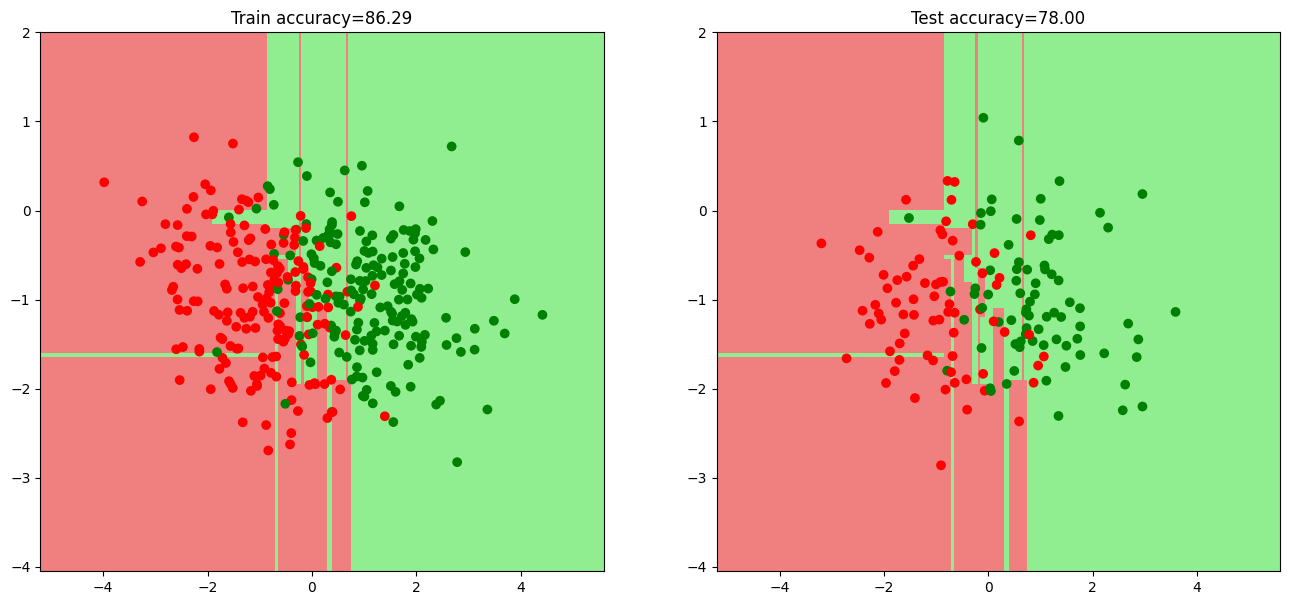

In [10]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# При попытке построить график в следующей строке (14) возникает ошибка о невозможности изменить массив
mesh_predictions = np.array(S.predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')